# Using Machine Learning Tools: Workshop 6

The aim of this week's workshop is to understand and evaluate the training process of models, in particular stochastic gradient descent, learning curves, and convergence.

You will use [Wisconsin Breast Cancer data set](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset), which is included in scikit learn (follow the link and read about what the dataset is)

Note: the link on webpage to the dataset is 'dead'. However, you can load the data directly using the below (as used in the below code):

`from sklearn.datasets import load_breast_cancer`

`data = load_breast_cancer()`



# Setup and loading data

Use the cells below to setup the notebook and load in data.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To plot even prettier figures
import seaborn as sn

# General data handling (pure numerics are better in numpy)
import pandas as pd

In [2]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

In [3]:
xarray = data.data
yarray = data.target
print(xarray.shape)
print(yarray.shape)
fullarray = np.concatenate((xarray,np.reshape(yarray,(-1,1))),axis=1)
print(fullarray.shape)

(569, 30)
(569,)
(569, 31)


In [4]:
fullarray[:,-1] = 1 - fullarray[:,-1]   # now invert the labels (so that malignant=1)
df = pd.DataFrame(fullarray,columns = list(data.feature_names) + ['target'])

# Splitting into separate datasets

Fill in the necessary sections so that the ratio for train:validation:test is 60:20:20 (think about how to do this in the two steps provided below).


In [7]:
from sklearn.model_selection import train_test_split

bigtrain_set, test_set = train_test_split(fullarray, test_size= 0.20, random_state=42, stratify=fullarray[:,-1])
train_set, val_set =train_test_split(bigtrain_set, test_size=0.25, random_state=42, stratify=bigtrain_set[:,-1])

### **Hint:** here we want to try and use the *stratify* option, which splits the sets whilst trying to keep the same proportions of the classification labels in each (hence it needs to know the labels). This is an important option to use in most classification tasks (and it can also be used for regression if you divide the data into discrete sets just for stratifying, such as small, medium, large values).

# Pipeline and SGD classifier

After this, a pre-processing pipeline is built and then a function called `sgdfn` is defined. This function creates an SGD classifier and calls it, one epoch at a time, from within a loop using the partial_fit method.  The SGD classifier needs to use the `warm_start=True` option in order to enable the partial_fit method to work in this way. (Note that an epoch is one pass through all the training data, whereas an iteration is one pass through a batch of training data. A batch is a smaller subset of the training data, although in our case they are the same as we are not splitting this small dataset into smaller batches, since we don’t need to.)

It is necessary to fit the pre-processing to the training set and then transform the training and validation datasets. You will need to fill in the appropriate calls to do this.

Within the loop the predict function is called on the validation data and then accuracy and loss (hinge_loss) are calculated. Fill in the necessary code for these steps.

After the loop the accuracy and loss are plotted, and these are the learning curves.

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

preproc_pl = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

In [33]:
# You will need to have modified this to allow more options to be passed into the initialisation of the sgd
# In the code below you will see some of the options that I've passed in, but you are free to choose your own

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, hinge_loss
X_train, y_train = train_set[:,:-1], train_set[:,-1]
X_val, y_val = val_set[:,:-1], val_set[:,-1]

def sgdfn(nsamp, learnrate, *args):
    sgd = SGDClassifier(warm_start=True, learning_rate='constant', eta0=learnrate)
    preproc_pl.fit(X_train)
    X_trainp = preproc_pl.transform(X_train)
    X_valp = preproc_pl.transform(X_val)
    res=[]

    for n in range(1000):
        sgd.partial_fit(X_trainp[:nsamp],y_train[:nsamp],classes=[0,1])
        y_val_pred = sgd.predict(X_valp)
        sgd_acc = accuracy_score(y_val,y_val_pred)
        sgd_loss = hinge_loss(y_val, y_val_pred)
        res += [[sgd_acc,sgd_loss]]

    res = np.array(res)

    plt.figure(figsize=(10,4))
    plt.subplot(121)
    plt.plot(res[:,0])
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.subplot(122)
    plt.plot(res[:,1])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.show()

    return [res[-1,0],res[-1,1]]

## Part 1: Initial fitting

Call the function with nsamp set to the maximum value for your training set and learnrate set to 1e-5.

An example output is shown below.

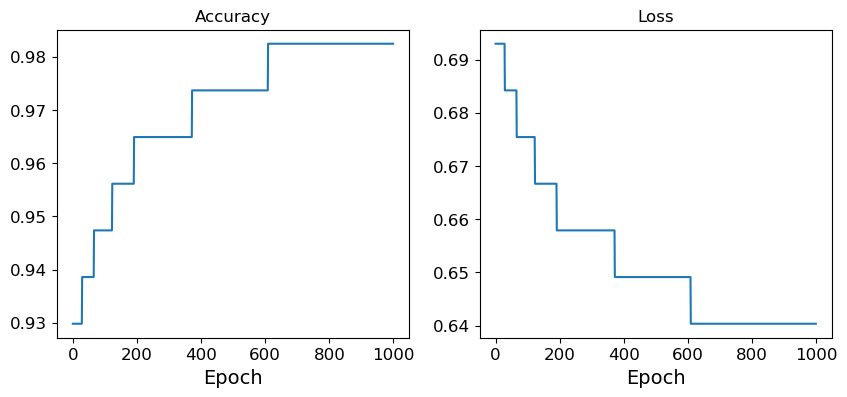

[0.9824561403508771, 0.6403508771929824]

In [34]:
ntrain = X_train.shape[0]
sgdfn(ntrain,1e-5, preproc_pl)

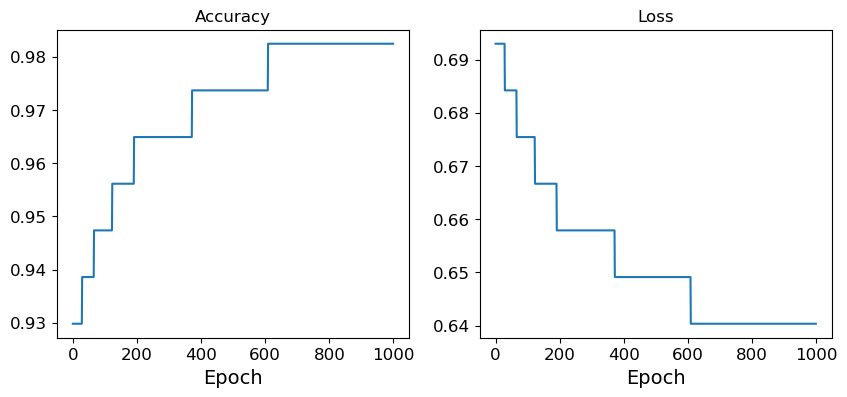

[0.9824561403508771, 0.6403508771929824]

In [35]:
ntrain = X_train.shape[0]
sgdfn(ntrain,1e-5)

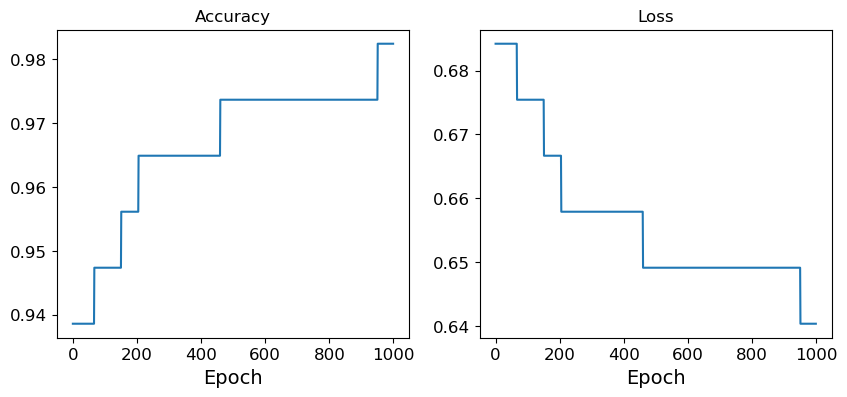

[0.9824561403508771, 0.6403508771929824]

In [36]:
# We can try different sample size
ntrain = int(X_train.shape[0]*0.8)
# Implement our function
sgdfn(ntrain,0.00001)

## Part 2: Exploring different learning rates

Explore the effect of different learning rates, trying to find the point where the learning rate is too low for it to learn and also the rate where it is too high and becomes unstable.  

**Hint:** you will need to explore a large range of values over many orders of magnitude.

In [ ]:
res=[]
for lr_exp in range(???):
    lr = ???
    print(f'Learning rate = {lr}')
    res += sgdfn(ntrain,lr)
print(res)

### **Take home message:** get used to seeing what things look like when the learning rate is too small or too large. Unstable results like the ones at the end sometimes produce models that are OK, but almost always the models could be better if the learning rate was better suited to them.

## Part 3: Effect of number of samples on learning rate

Explore the effect that different training set sizes (via nsamp) has on the learning curves.  How does the training set size effect the limits of the learning rate - that is, the values when the learning rate becomes too low or too high?  Keep a record of the values for several training set sizes and summarize your findings as a plot or a table.

In [ ]:
res=[]
for nsamp in range(???):
    ???

In [ ]:
for lr_exp in np.arange(???):
    ???

### **Take home message:** there is a relatively narrow zone sometimes of learning rates between too slow and too unstable. This also depends on the data (and the task) so learning rates need to be appropriately tuned for each problem.

## Part 4: Learning rate options

Using nsamp=100, find what you consider is the best learning rate.  Then compare this to what happens when you set learning_rate=‘optimal’ instead.  Do this by taking another argument in your function.  Show the learning curves in each case.  Can you do better than the ‘optimal’ setting?

In [ ]:
# An example of how to set the learning rate to optimal
sgdfn(ntrain,1e-5,learntype='optimal',loop=False)

In [ ]:
# You can also set the early stoppinf criteria
sgdfn(ntrain, 1e-5, learntype='constant', loop=False, early_stopping=True, verbose=0, tol=???, n_iter_no_change=???)

In [ ]:
# Now try and could some other options

### **Take home message:** the 'optimal' methods may or may not do better than simpler ones. Don't assume that the latest method or the method with the most impressive name/maths will do the best. Try a range of different things whenever possible. And remember that many of these things are stochastic, so if you ran it again, you'll get a different result (a lot of the time). However, also consider how much time or computational resources you have, as the later versions need far fewer epochs/iterations (in this case it is pretty trivial, but for very big datasets and very big models, such as in deep learning, the computational time can be a big issue to consider).

## Part 5: Regularisation (plus the early stopping extension)

To have a basic idea about regularisation, you can download the additional `regularisation.ipynb` notebook on MyUni.

After that, follor with the next activities:
Instead of using the function above, create your own pipeline including an SGDClassifier and use this to fit to training data and predict validation data.  Calculate the performance metrics (accuracy and loss) for this, but as it is a single call you cannot get a learning curve from this.  Record your results as these will be a baseline for the next experiments.

The SGDClassifier incorporates L2 regularisation by default.  It can be controlled by the parameter alpha. Try varying this over many orders to magnitude until you find a value that causes a noticeable change in the results.
Make a plot of the accuracy versus alpha value.

The type of regularisation used is controlled by the penalty parameter.  Look at the available options and try the others, making a similar plot for each of them.

Some example outputs are shown below.

**Question:** What do you think is the best setting for regularisation?

Alpha = 1e-08
Number of epochs/iterations performed was 6
Alpha = 1e-07
Number of epochs/iterations performed was 6
Alpha = 1e-06
Number of epochs/iterations performed was 6
Alpha = 1e-05
Number of epochs/iterations performed was 6
Alpha = 0.0001
Number of epochs/iterations performed was 6
Alpha = 0.001
Number of epochs/iterations performed was 6
Alpha = 0.01
Number of epochs/iterations performed was 6
Alpha = 0.1
Number of epochs/iterations performed was 6
Alpha = 1.0
Number of epochs/iterations performed was 6
Alpha = 10.0
Number of epochs/iterations performed was 6
Alpha = 100.0
Number of epochs/iterations performed was 6
Alpha = 1000.0
Number of epochs/iterations performed was 6
Alpha = 10000.0
Number of epochs/iterations performed was 6
Alpha = 100000.0
Number of epochs/iterations performed was 6
Alpha = 1000000.0
Number of epochs/iterations performed was 6
Alpha = 10000000.0
Number of epochs/iterations performed was 6
Alpha = 1e-08
Number of epochs/iterations performed was 6
Alph

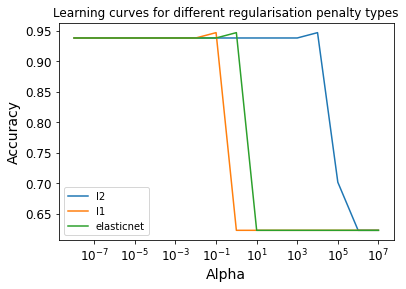

In [ ]:
for pen in ['l2','l1','elasticnet']:
    ???
plt.title(f'Learning curves for different regularisation penalty types')
plt.ylabel('Accuracy')
plt.xlabel('Alpha')
plt.legend(['l2','l1','elasticnet'])
plt.show()

### **Take home message:** these are *many orders of magnitude* different from one another in terms of their effect on the same dataset. So whenever you are investigating parameters for this, or other things, remember that you should try a very wide range of values to make sure that you are seeing the full effect. In this case regularisation isn't really needed, but too much lowers the performance, which is typical.

## Part 6: Model comparison and test evaluation

Model Comparison:
We complete the standard workflow as usual - choose what you think are the best settings for all of the above parameters.

Question: Which of the above parameters (i.e. learning rate, type of learning method or regularisation) has the biggest effect on final performance?

Measure the performance of this method on the current validation set.

Re-train the method on the combined set of training and validation data.
Measure the performance of this on the test set.

**Question:** How does this performance compare?  What did you expect?

In [ ]:
sgd = SGDClassifier(learning_rate='constant', eta0=1e-5,
                        early_stopping=False,
                        validation_fraction=0.1, penalty='l2')
sgd_pipe = Pipeline([('preproc',preproc_pl),('sgd',sgd)])

sgd_pipe.fit(X_train,y_train)
y_val_pred = sgd_pipe.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)

sgd_pipe.fit(np.concatenate((X_train,X_val),axis=0),np.concatenate((y_train,y_val),axis=0))
y_test_pred = sgd_pipe.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

print(f'Validation and Test accuracies are: {val_acc} and {test_acc}')

Validation and Test accuracies are: 0.9473684210526315 and 0.956140350877193


### **Take home message:** although the validation accuracy is, on average, biased by the selection process the random element of sample selection often means that it is hard to know if the test accuracy will be more or less than the validation accuracy, but it should normally be similar. If it is very different then you either have a lot of random variation (often due to sample sizes being too small) or you have a bigger problem in the code or in the selection of the samples.